In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# filtermasken generator
from math import ceil

xtrans = """gbggrg
rgrbgb
gbggrg
grggbg
bgbrgr
grggbg
"""
bayer = """gr
bg"""


def filtermask_from_str(w, h, pattern=bayer):
    d = {"r": [1, 0, 0], "g": [0, 1, 0], "b": [0, 0, 1]}
    a = np.array([[d[y] for y in x]
                  for x in pattern.splitlines()]).astype("float32")
    (ph, pw, _) = a.shape
    return np.tile(a, (ceil(h / ph), ceil(w / pw), 1))[0:h, 0:w]

## Trainingsdaten vorbereiten
Bilder zunächst um 50% runterskalieren um mögliche Mängel des Demosaic Verfahrens der Kamera zu verstecken. Dann Bilder in eine Form bringen die die Ausgabe eines Sensors mit Bayer-Filter nachahmt.

In [3]:
from pathlib import Path
from PIL import Image
import numpy as np
from itertools import product
from random import seed, shuffle

tile_size = 32

training_dataset = []

for p in Path("./training_images").iterdir():
    if p.is_file():
        im = Image.open(p).convert('RGB')

        im = im.resize((im.width // 2, im.height // 2), Image.LANCZOS)

        im_y = np.asarray(im, 'float32') / 255

        # Bayer Pattern erzeugen
        im_x = im_y * filtermask_from_str(im.width, im.height)

        # bild aufteilen
        (h, w, _) = im_x.shape
        (h, w) = (h // tile_size, w // tile_size)

        for i, j in product(range(w), range(h)):
            tile_x = im_x[j * tile_size:(j + 1) * tile_size,
                          i * tile_size:(i + 1) * tile_size, ].copy()
            tile_y = im_y[j * tile_size:(j + 1) * tile_size,
                          i * tile_size:(i + 1) * tile_size, ].copy()
            training_dataset.append((tile_x, tile_y))

seed(42)
shuffle(training_dataset)

train_x, train_y = zip(*training_dataset)

train_x = np.array(train_x)
train_y = np.array(train_y)

### Mosaic zur Kontrolle anzeigen

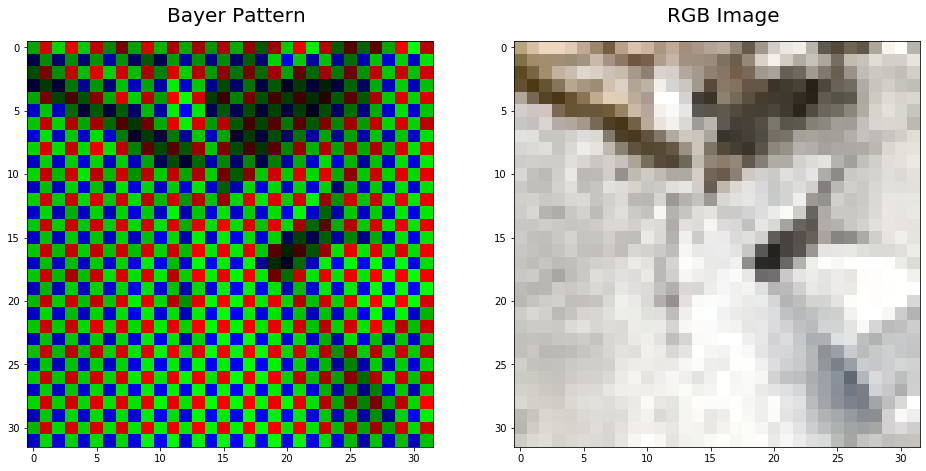

In [4]:
idx = 200

plt.figure(figsize=(16, 16 * 2))
plt.subplot(1, 2, 1)
plt.imshow(train_x[idx], interpolation="nearest")
plt.text(16, -2, "Bayer Pattern", fontsize=20, horizontalalignment='center')
plt.subplot(1, 2, 2)
plt.imshow(train_y[idx], interpolation="nearest")
plt.text(16, -2, "RGB Image", fontsize=20, horizontalalignment='center')

plt.show()

## Modell erstellen

### Tensorflow soll sich nur den Speicher holen den es braucht anstatt sich alles unter den Nagel zu reißen
([Code aus Tensorflow Guide](https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth))

In [5]:
import keras
from keras import backend as K

if K.backend() == 'tensorflow':
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


 Hatte PSNRLoss in einem anderem Projekt benutzt und war besser als die builtin metrics

In [6]:
def PSNRLoss(y_true, y_pred):
    """
    PSNR is Peek Signal to Noise Ratio, which is similar to mean squared error.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    When providing an unscaled input, MAXp = 255. Therefore 20 * log10(255)== 48.1308036087.
    However, since we are scaling our input, MAXp = 1. Therefore 20 * log10(1) = 0.
    Thus we remove that component completely and only compute the remaining MSE component.
    """
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)

Vorerst nur ein sehr einfacher Autoencoder

In [7]:
from keras.layers import Conv2D,Conv2DTranspose,Input
from keras.models import Model


inp = Input(shape=(tile_size, tile_size, 3))

conv1 = Conv2D(64, (3, 3), activation='relu', strides=(2,2), padding='same')(inp)
deconv1 = Conv2DTranspose(64, (3, 3),activation='relu', strides=(2, 2), padding='same')(conv1)
out = Conv2DTranspose(3, (5, 5), activation='linear', padding='same')(deconv1)

model = Model(inputs=inp, outputs=out)  
model.compile(loss=keras.losses.mean_squared_error,
             optimizer=keras.optimizers.Adam(),
             metrics=[PSNRLoss])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 3)         4803      
Total params: 43,523
Trainable params: 43,523
Non-trainable params: 0
_________________________________________________________________


In [8]:
%%time
from keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='loss', patience=5)
hist = model.fit(train_x, train_y,
                 batch_size=32,
                 epochs=100,
                 shuffle=True,
                 validation_split=0.9,
                 callbacks=[early_stopping],
                 verbose=2)

Train on 3266 samples, validate on 29399 samples
Epoch 1/100
 - 4s - loss: 0.0256 - PSNRLoss: 18.7731 - val_loss: 0.0032 - val_PSNRLoss: 25.0287
Epoch 2/100
 - 3s - loss: 0.0020 - PSNRLoss: 27.2947 - val_loss: 0.0013 - val_PSNRLoss: 28.9767
Epoch 3/100
 - 3s - loss: 0.0010 - PSNRLoss: 30.0789 - val_loss: 7.5318e-04 - val_PSNRLoss: 31.3428
Epoch 4/100
 - 3s - loss: 6.4355e-04 - PSNRLoss: 32.0301 - val_loss: 5.1364e-04 - val_PSNRLoss: 33.0254
Epoch 5/100
 - 3s - loss: 4.7090e-04 - PSNRLoss: 33.4619 - val_loss: 4.1764e-04 - val_PSNRLoss: 33.9247
Epoch 6/100
 - 3s - loss: 3.9883e-04 - PSNRLoss: 34.2169 - val_loss: 3.5581e-04 - val_PSNRLoss: 34.6343
Epoch 7/100
 - 3s - loss: 3.4595e-04 - PSNRLoss: 34.8129 - val_loss: 3.4129e-04 - val_PSNRLoss: 34.8005
Epoch 8/100
 - 3s - loss: 3.2063e-04 - PSNRLoss: 35.1478 - val_loss: 3.0356e-04 - val_PSNRLoss: 35.3238
Epoch 9/100
 - 3s - loss: 2.9591e-04 - PSNRLoss: 35.4525 - val_loss: 3.0908e-04 - val_PSNRLoss: 35.2272
Epoch 10/100
 - 3s - loss: 2.8086e-

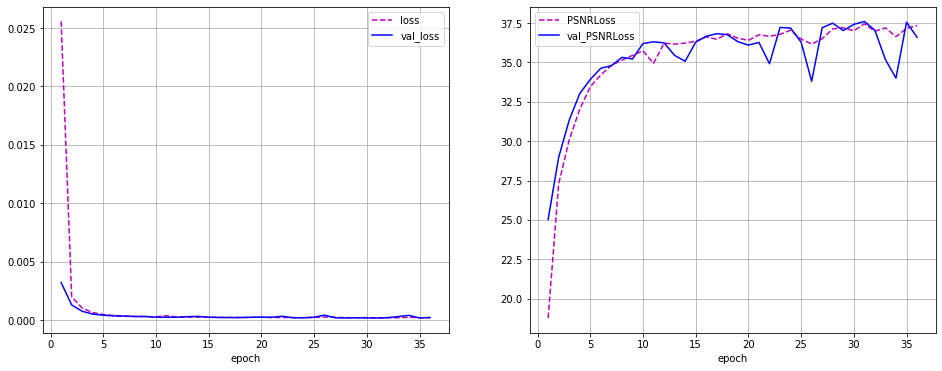

maximum validation PSNRLoss: 37.6064
minimum validation loss: 0.000181


In [9]:
import helper
helper.plot_model(hist, size=(16, 6))

x = max(hist.history['val_PSNRLoss'])
print(f"maximum validation PSNRLoss: {x:.4f}")
x = min(hist.history['val_loss'])
print(f"minimum validation loss: {x:f}")

## Testlauf
(ist natürlich verfälscht da hier ein bild aus dem trainingsdatensatz verwendet wird)

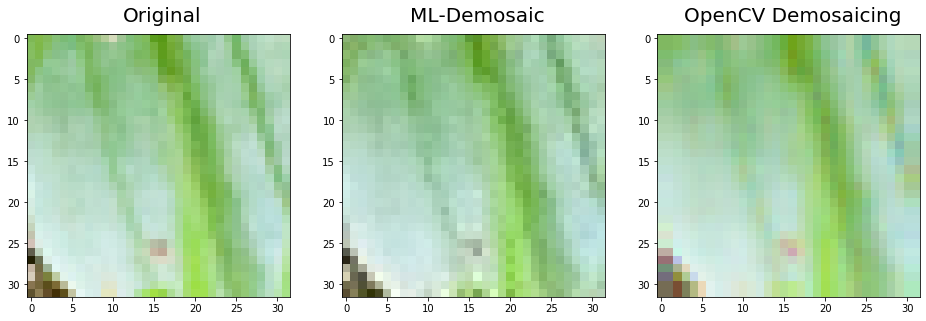

In [10]:
import cv2
i = 12

plt.figure(figsize=(16, 16*3))

# original bild anzeigen
plt.subplot(1, 3, 1)
plt.imshow(train_y[i], interpolation="nearest")
plt.text(16, -2, "Original", fontsize=20, horizontalalignment='center')

# demosicing durch den autoencoder
plt.subplot(1, 3, 2)
decoded = model.predict(train_x[i:i + 1])
decoded = np.clip(decoded, 0, 1)
plt.imshow(decoded[0])
plt.text(16, -2, "ML-Demosaic", fontsize=20, horizontalalignment='center')

# opencv demosaicing algorithmus zum vergleich (irgendwas stimmt hier noch nicht)
plt.subplot(1, 3, 3)
(h, w, _) = train_x[i].shape
# rgb bayer bild in graustufen umwandeln
a = ((train_x[i][..., 0] + train_x[i][..., 1] + train_x[i][..., 2]) * 255).astype("uint8")
b = cv2.cvtColor(a, cv2.COLOR_BAYER_GB2RGB)
plt.imshow(b, interpolation="nearest")
plt.text(16, -2, "OpenCV Demosaicing",
         fontsize=20, horizontalalignment='center')

plt.show()